In [2]:

%pip install pandas numpy scikit-learn matplotlib seaborn joblib shap xgboost lightgbm category_encoders --quiet

# Imports
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import joblib

Note: you may need to restart the kernel to use updated packages.


In [3]:
# optional libraries
import shap
import xgboost as xgb
import lightgbm as lgb
import category_encoders as ce

sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)

print('Environment ready')

Environment ready


In [4]:
# Configuration
DATA_PATH = 'hotel_booking.csv'  # change if needed
RANDOM_SEED = 42

# Load
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

raw = pd.read_csv(DATA_PATH)
print('Raw shape:', raw.shape)
raw.head()

Raw shape: (119390, 36)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Ernest Barnes,Ernest.Barnes31@outlook.com,669-792-1661,************4322
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,Andrea Baker,Andrea_Baker94@aol.com,858-637-6955,************9157
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Rebecca Parker,Rebecca_Parker@comcast.net,652-885-2745,************3734
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,Laura Murray,Laura_M@gmail.com,364-656-8427,************5677
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,Linda Hines,LHines@verizon.com,713-226-5883,************5498


In [5]:
## 4 — Quick data snapshot


raw.info()
raw.describe(include='all').T.head(20)
raw.isnull().sum().sort_values(ascending=False).head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

company                      112593
agent                         16340
country                         488
children                          4
arrival_date_year                 0
lead_time                         0
is_canceled                       0
hotel                             0
stays_in_weekend_nights           0
stays_in_week_nights              0
arrival_date_day_of_month         0
arrival_date_month                0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
adults                            0
arrival_date_week_number          0
dtype: int64

In [6]:
# target check
if 'is_canceled' in raw.columns:
    display(raw['is_canceled'].value_counts(normalize=True))
else:
    raise ValueError("Target column 'is_canceled' not found — check dataset column names")

is_canceled
0    0.629584
1    0.370416
Name: proportion, dtype: float64

In [7]:
## 5 — Cleaning & leakage removal


# Make a working copy
df = raw.copy()

# Drop obvious duplicates
df.drop_duplicates(inplace=True)

In [8]:
# Drop columns that are IDs or leakage
possible_leakage = ['reservation_status', 'reservation_status_date', 'agent', 'company', 'reservation_id', 'name', 'email', 'phone']
for c in possible_leakage:
    if c in df.columns:
        df.drop(columns=c, inplace=True, errors='ignore')


In [9]:
# Quick NA handling: keep strategy simple and reproducible
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Fill numeric with median
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
# Fill categoricals with 'Unknown'
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

print('After cleaning:', df.shape)

After cleaning: (119390, 30)


In [10]:
## 6 — Feature engineering (business features)


# Derived features
if set(['stays_in_weekend_nights','stays_in_week_nights']).issubset(df.columns):
    df['length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

if set(['adults','children','babies']).issubset(df.columns):
    df['total_guests'] = df['adults'].fillna(0) + df['children'].fillna(0) + df['babies'].fillna(0)
    df['adr_per_person'] = df['adr'].fillna(df['adr'].median()) / df['total_guests'].replace(0,1)

# Booking month if available
if set(['arrival_date_year','arrival_date_month','arrival_date_day_of_month']).issubset(df.columns):
    df['arrival_date'] = pd.to_datetime(df['arrival_date_year'].astype(str) + '-' + df['arrival_date_month'].astype(str) + '-' + df['arrival_date_day_of_month'].astype(str), errors='coerce')
    df['arrival_month'] = df['arrival_date'].dt.month.fillna(0).astype(int)

# Flag repeat guests
if 'is_repeated_guest' in df.columns:
    df['is_repeated_guest'] = df['is_repeated_guest'].astype(int)

print('Engineered features added.')

Engineered features added.


In [59]:
# ✅ Feature Engineering (consistent for training + testing)
def add_business_features(df):
    df = df.copy()

    # Always create all required columns, even if missing in input
    df['stays_in_weekend_nights'] = df.get('stays_in_weekend_nights', 0)
    df['stays_in_week_nights'] = df.get('stays_in_week_nights', 0)
    df['adults'] = df.get('adults', 0)
    df['children'] = df.get('children', 0)
    df['babies'] = df.get('babies', 0)
    df['adr'] = df.get('adr', 0)
    df['arrival_date_year'] = df.get('arrival_date_year', 2020)
    df['arrival_date_month'] = df.get('arrival_date_month', 'January')
    df['arrival_date_day_of_month'] = df.get('arrival_date_day_of_month', 1)
    df['is_repeated_guest'] = df.get('is_repeated_guest', 0)

    # Derived features
    df['length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
    df['total_guests'] = df['adults'].fillna(0) + df['children'].fillna(0) + df['babies'].fillna(0)
    df['adr_per_person'] = df['adr'].fillna(df['adr'].median()) / df['total_guests'].replace(0, 1)

    # Booking month
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(str) + '-' +
        df['arrival_date_month'].astype(str) + '-' +
        df['arrival_date_day_of_month'].astype(str),
        errors='coerce'
    )
    df['arrival_month'] = df['arrival_date'].dt.month.fillna(0).astype(int)

    # Flag repeated guests
    df['is_repeated_guest'] = df['is_repeated_guest'].astype(int)

    return df
Ah — perfect question 👏

If you’re using the exact same Excel file that you trained your model on (e.g. hotel_booking.xls) and you’re still getting “columns are missing”, here’s the simple explanation 👇

⚠️ What’s happening:

During training, you added new columns (like length_of_stay, total_guests, adr_per_person, arrival_month) inside your notebook — they were created in memory (inside your df variable).

But when you saved your model, you did not save the modified DataFrame with those new columns — only the model was saved.

So, when you reload the original hotel_booking.xls, those engineered columns don’t exist in the file (because they were never written back)

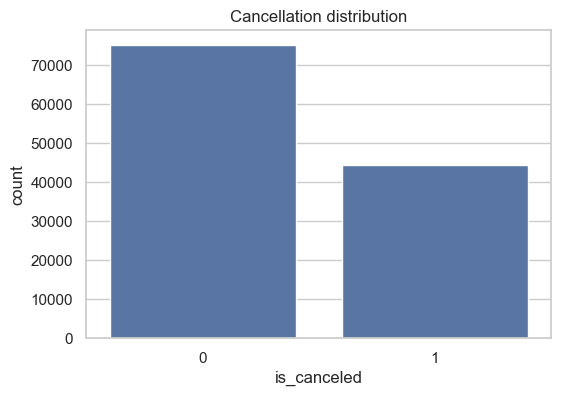

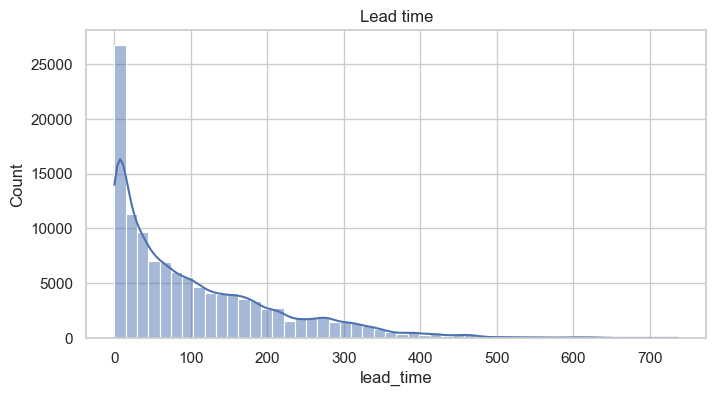

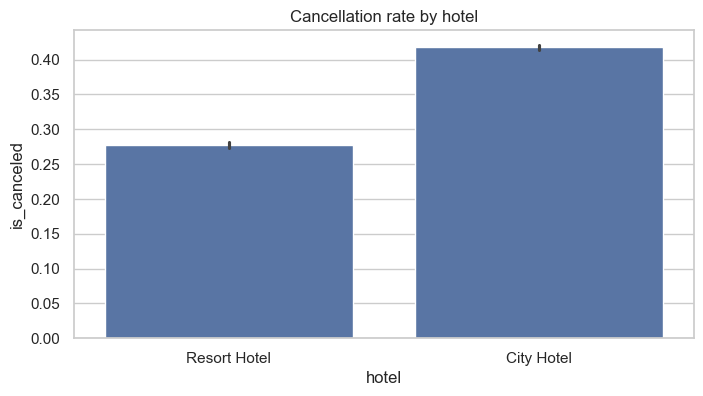

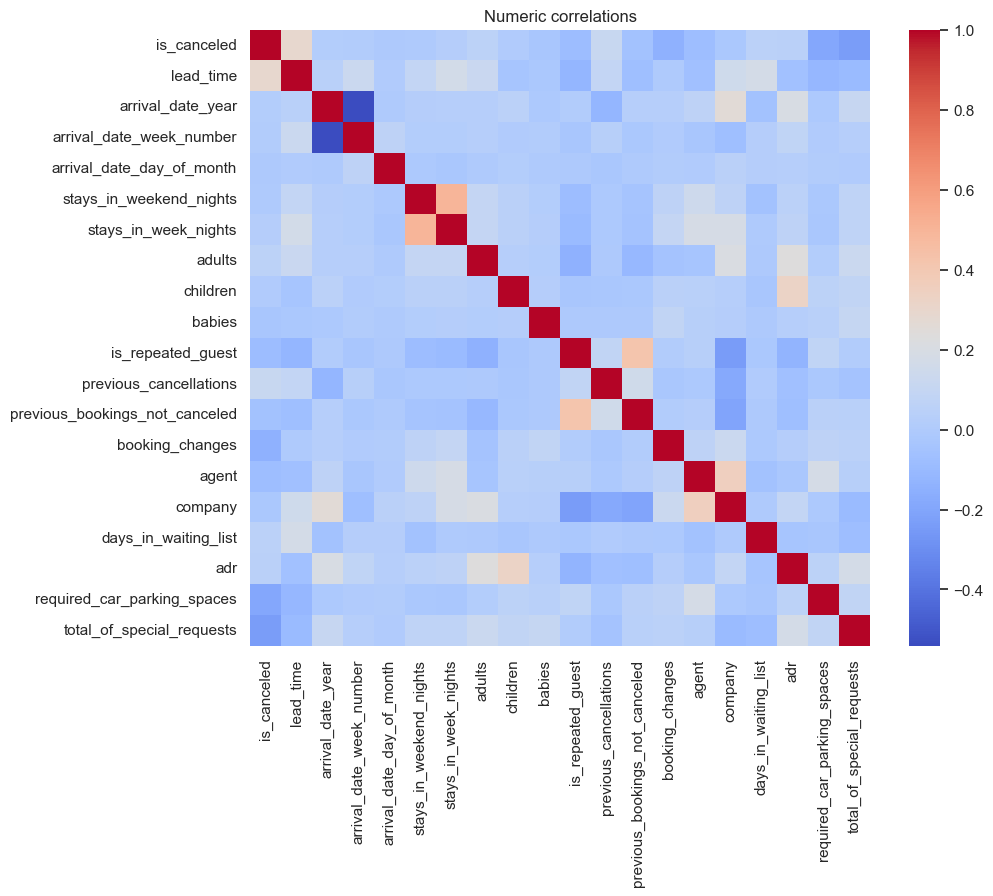

In [60]:

## 7 — Exploratory Data Analysis (more professional)


# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='is_canceled', data=df)
plt.title('Cancellation distribution')
plt.show()

# Lead_time distribution
if 'lead_time' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['lead_time'], bins=50, kde=True)
    plt.title('Lead time')
    plt.show()

# Cancel by hotel type
if 'hotel' in df.columns:
    plt.figure(figsize=(8,4))
    sns.barplot(x='hotel', y='is_canceled', data=df)
    plt.title('Cancellation rate by hotel')
    plt.show()

# Correlation heatmap (numeric)
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=['float64','int64']).corr(), cmap='coolwarm')
plt.title('Numeric correlations')
plt.show()

In [61]:
## 8 — Prepare features (avoid high-cardinality explosion)


TARGET = 'is_canceled'
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Identify numeric and categorical columns
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Remove extremely high-cardinality columns from cat_features (threshold can be tuned)
high_card_thresh = 50
high_card_cols = [c for c in cat_features if X[c].nunique() > high_card_thresh]
print('High-cardinality columns to drop or encode separately:', high_card_cols)

# Drop them for now (or handle with target/frequency encoding later)
X.drop(columns=high_card_cols, inplace=True)

# Recompute feature lists
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print('Final numeric:', len(num_features), 'Final categorical:', len(cat_features))

High-cardinality columns to drop or encode separately: ['country', 'reservation_status_date', 'name', 'email', 'phone-number', 'credit_card']
Final numeric: 19 Final categorical: 10


In [13]:
## 9 — Train/test split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print('Train', X_train.shape, 'Test', X_test.shape)

Train (95512, 31) Test (23878, 31)


In [14]:
## 10 — Preprocessing pipelines (frequency encoding for high-cardinality optional)


# Use StandardScaler for numeric
numeric_transformer = Pipeline([('scaler', StandardScaler())])

# Use Ordinal/Target/Frequency encoders for categorical to avoid huge one-hot
# We'll use category_encoders' TargetEncoder for a better fit (or FrequencyEncoder)
try:
    from category_encoders import TargetEncoder
    cat_encoder = TargetEncoder()
    use_target_encoder = True
except Exception:
    # fallback to Ordinal
    from sklearn.preprocessing import OrdinalEncoder
    cat_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    use_target_encoder = False

categorical_transformer = Pipeline([('encoder', cat_encoder)])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')

print('Preprocessor ready (target encoder used:', use_target_encoder, ')')

Preprocessor ready (target encoder used: True )


In [15]:
## 11 — Model comparison (with cross-val) and selection


models = {
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_SEED),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_SEED),
    'LightGBM': lgb.LGBMClassifier(random_state=RANDOM_SEED),
    'LogisticRegression': LogisticRegression(max_iter=2000)
}

results = {}
for name, estimator in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', estimator)])
    pipe.fit(X_train, y_train)  # quick fit
    y_proba = pipe.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_proba)
    results[name] = auc
    print(f'{name} AUC = {auc:.4f}')

results_df = pd.DataFrame.from_dict(results, orient='index', columns=['roc_auc']).sort_values('roc_auc', ascending=False)
results_df



RandomForest AUC = 0.9341
GradientBoosting AUC = 0.8867
XGBoost AUC = 0.9203
[LightGBM] [Info] Number of positive: 35379, number of negative: 60133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1246
[LightGBM] [Info] Number of data points in the train set: 95512, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370414 -> initscore=-0.530440
[LightGBM] [Info] Start training from score -0.530440
LightGBM AUC = 0.9132
LogisticRegression AUC = 0.8468


,roc_auc
RandomForest,0.934133
XGBoost,0.920274
LightGBM,0.913242
GradientBoosting,0.886651
LogisticRegression,0.846766


In [16]:
## 12 — Cross-validation and stability check


best_name = results_df.index[0]
print('Best model by AUC:', best_name)

# Cross-validate best model
best_est = models[best_name]
pipe_best = Pipeline([('preprocessor', preprocessor), ('clf', best_est)])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
scores = cross_val_score(pipe_best, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)
print('CV AUC mean/std:', scores.mean(), scores.std())

Best model by AUC: RandomForest
CV AUC mean/std: 0.9356138578492359 0.0009289126822840115


In [17]:
## 13 — Hyperparameter tuning (example for RandomForest or best model)


# Example: tune RandomForest (only if it is the chosen model or try for top models)
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'clf__n_estimators': [100,200,400],
    'clf__max_depth': [None, 10, 20, 40],
    'clf__min_samples_split': [2, 5, 10]
}

search = RandomizedSearchCV(Pipeline([('preprocessor', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_SEED))]),
                            param_distributions=param_dist, n_iter=12, cv=3, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_SEED)
search.fit(X_train, y_train)
print('Best params:', search.best_params_)
print('Best CV AUC:', search.best_score_)
best_pipe = search.best_estimator_

Best params: {'clf__n_estimators': 200, 'clf__min_samples_split': 5, 'clf__max_depth': 40}
Best CV AUC: 0.9283855235457024


Test ROC AUC: 0.9340210647184823
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     15033
           1       0.87      0.75      0.81      8845

    accuracy                           0.87     23878
   macro avg       0.87      0.84      0.85     23878
weighted avg       0.87      0.87      0.87     23878



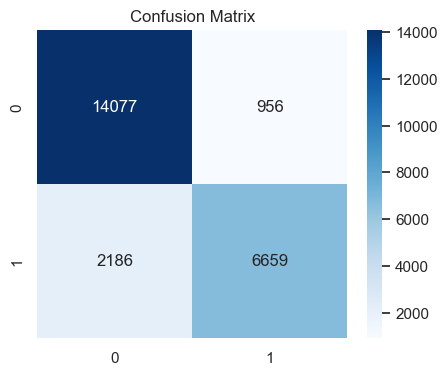

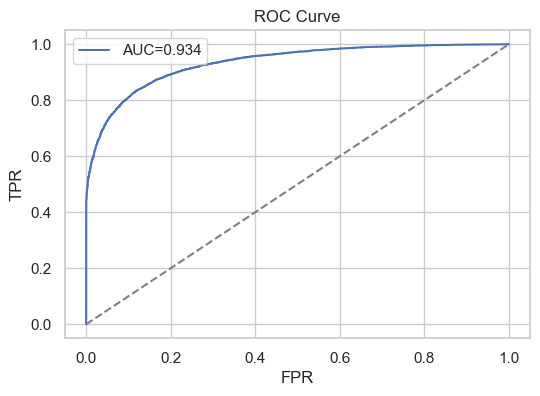

In [18]:
## 14 — Final evaluation & diagnostic plots


# Use best_pipe if tuning used, else pipe_best
model_pipe = best_pipe if 'best_pipe' in globals() else pipe_best

# Fit final on train and evaluate
model_pipe.fit(X_train, y_train)
y_pred = model_pipe.predict(X_test)
y_proba = model_pipe.predict_proba(X_test)[:,1]

print('Test ROC AUC:', roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

# Confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test,y_proba):.3f}')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

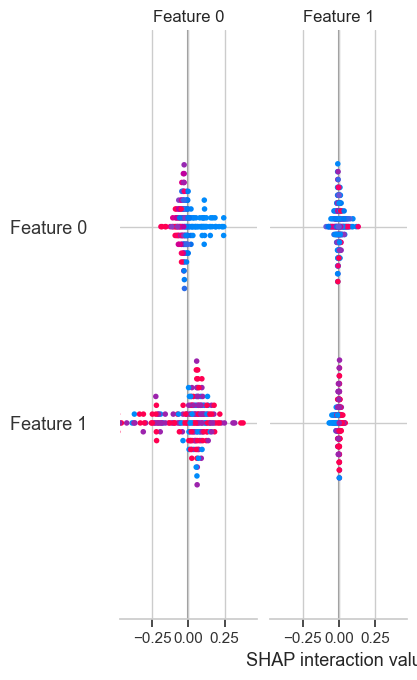

In [19]:
## 15 — Interpretability: SHAP and feature importances


# Compute SHAP for tree models — sample to speed up
sample_for_shap = X_test.sample(n=min(200, X_test.shape[0]), random_state=RANDOM_SEED)

# If pipeline used target encoder, we need to transform sample via preprocessor
X_trans = model_pipe.named_steps['preprocessor'].transform(sample_for_shap)

# Use TreeExplainer for tree-based final estimator
final_clf = model_pipe.named_steps['clf']

try:
    explainer = shap.TreeExplainer(final_clf)
    shap_values = explainer.shap_values(X_trans)
    shap.summary_plot(shap_values, X_trans)
except Exception as e:
    print('SHAP TreeExplainer failed:', e)
    # Fall back: if not tree model, use KernelExplainer on small sample
    explainer = shap.Explainer(model_pipe.predict, sample_for_shap)
    shap_values = explainer(sample_for_shap)
    shap.summary_plot(shap_values, sample_for_shap)

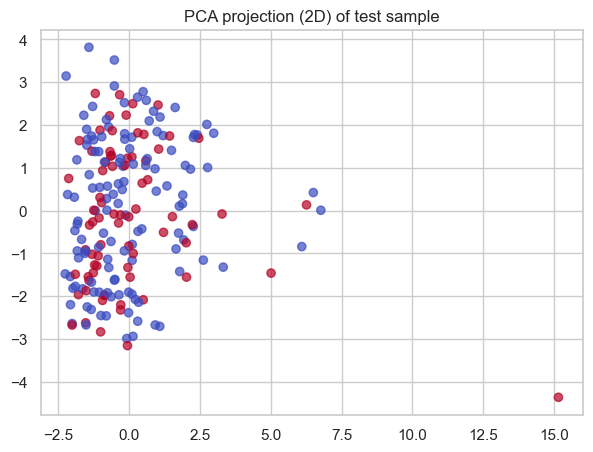

In [21]:
## 16 — PCA Visualization (optional)


from sklearn.decomposition import PCA
X_small = model_pipe.named_steps['preprocessor'].transform(X_test.sample(n=min(200, X_test.shape[0]), random_state=RANDOM_SEED))
if hasattr(X_small, 'toarray'):
    X_small = X_small.toarray()

pca = PCA(n_components=2, random_state=RANDOM_SEED)
proj = pca.fit_transform(X_small)
plt.figure(figsize=(7,5))
plt.scatter(proj[:,0], proj[:,1], c=y_test.sample(n=proj.shape[0], random_state=RANDOM_SEED), cmap='coolwarm', alpha=0.7)
plt.title('PCA projection (2D) of test sample')
plt.show()

In [23]:
## 17 — Model saving and simple API example


# Save model
joblib.dump(model_pipe, 'hotel_cancellation_model_finalll.pkl')
print('Saved model to hotel_cancellation_model_final.pkl')

# Example Flask-like prediction snippet (to paste into a tiny API)
print('\n# API example (pseudo-code):')
print('''
from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)
model = joblib.load('hotel_cancellation_model_finalll.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame([data])
    proba = model.predict_proba(df)[:,1][0]
    return jsonify({'cancellation_probability': float(proba)})

if __name__ == '__main__':
    app.run(debug=True)
''')

Saved model to hotel_cancellation_model_final.pkl

# API example (pseudo-code):

from flask import Flask, request, jsonify
import joblib
import pandas as pd

app = Flask(__name__)
model = joblib.load('hotel_cancellation_model_finalll.pkl')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame([data])
    proba = model.predict_proba(df)[:,1][0]
    return jsonify({'cancellation_probability': float(proba)})

if __name__ == '__main__':
    app.run(debug=True)



In [28]:
## 18 — Monitoring simulation & next steps (Markdown)

print('''
### Model Monitoring (Simulation)
- Log predictions and actual outcomes daily
- Track drift in feature distributions and model AUC
- Retrain monthly or upon drift detection

### Next Steps
- Deploy as REST API + Streamlit dashboard
- Add unit tests for preprocessing and endpoint
- Set up CI to retrain & validate models'''
)


### Model Monitoring (Simulation)
- Log predictions and actual outcomes daily
- Track drift in feature distributions and model AUC
- Retrain monthly or upon drift detection

### Next Steps
- Deploy as REST API + Streamlit dashboard
- Add unit tests for preprocessing and endpoint
- Set up CI to retrain & validate models


In [53]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']


In [51]:
import joblib
model = joblib.load("hotel_cancellation_model_finalll.pkl")
print("✅ Model loaded successfully.")


✅ Model loaded successfully.


In [64]:
# Derived features
if set(['stays_in_weekend_nights','stays_in_week_nights']).issubset(df.columns):
    df['length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

if set(['adults','children','babies']).issubset(df.columns):
    df['total_guests'] = df['adults'].fillna(0) + df['children'].fillna(0) + df['babies'].fillna(0)
    df['adr_per_person'] = df['adr'].fillna(df['adr'].median()) / df['total_guests'].replace(0,1)

# Booking month
if set(['arrival_date_year','arrival_date_month','arrival_date_day_of_month']).issubset(df.columns):
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(str) + '-' +
        df['arrival_date_month'].astype(str) + '-' +
        df['arrival_date_day_of_month'].astype(str),
        errors='coerce'
    )
    df['arrival_month'] = df['arrival_date'].dt.month.fillna(0).astype(int)

# Flag repeated guests
if 'is_repeated_guest' in df.columns:
    df['is_repeated_guest'] = df['is_repeated_guest'].astype(int)

print("✅ Engineered features added.")


✅ Engineered features added.


✅ Engineered features added.

📊 Model Performance:
🔹 Accuracy:  0.9550
🔹 Precision: 0.9647
🔹 Recall:    0.9119
🔹 F1 Score:  0.9375
🔹 ROC AUC:   0.9886


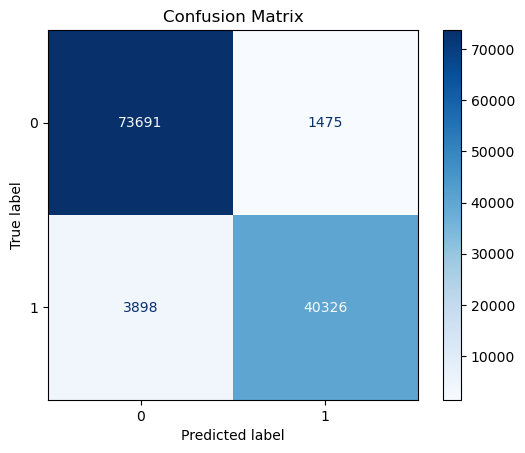

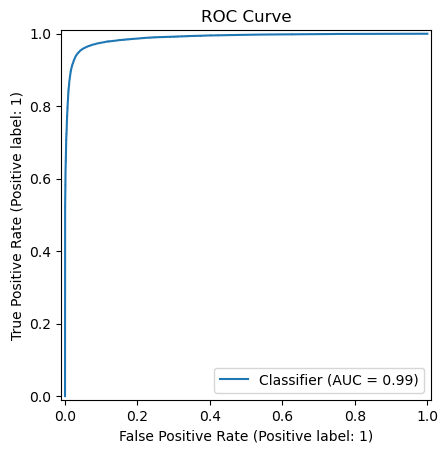

In [2]:
import pandas as pd
import joblib
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt

# ==================================================
# 1️⃣ Load Data and Model
# ==================================================
df = pd.read_csv("hotel_booking.csv")   # or your CSV
model = joblib.load("hotel_cancellation_model_finalll.pkl")  # trained model

# ==================================================
# 2️⃣ Apply Feature Engineering (same as training)
# ==================================================
if set(['stays_in_weekend_nights','stays_in_week_nights']).issubset(df.columns):
    df['length_of_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']

if set(['adults','children','babies']).issubset(df.columns):
    df['total_guests'] = df['adults'].fillna(0) + df['children'].fillna(0) + df['babies'].fillna(0)
    df['adr_per_person'] = df['adr'].fillna(df['adr'].median()) / df['total_guests'].replace(0,1)

if set(['arrival_date_year','arrival_date_month','arrival_date_day_of_month']).issubset(df.columns):
    df['arrival_date'] = pd.to_datetime(
        df['arrival_date_year'].astype(str) + '-' +
        df['arrival_date_month'].astype(str) + '-' +
        df['arrival_date_day_of_month'].astype(str),
        errors='coerce'
    )
    df['arrival_month'] = df['arrival_date'].dt.month.fillna(0).astype(int)

if 'is_repeated_guest' in df.columns:
    df['is_repeated_guest'] = df['is_repeated_guest'].astype(int)

print("✅ Engineered features added.")

# ==================================================
# 3️⃣ Split Features and Target
# ==================================================
TARGET = "is_canceled"
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# ==================================================
# 4️⃣ Make Predictions
# ==================================================
y_pred = model.predict(X)
y_proba = model.predict_proba(X)[:, 1]

# ==================================================
# 5️⃣ Calculate Metrics
# ==================================================
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_proba)

print("\n📊 Model Performance:")
print(f"🔹 Accuracy:  {acc:.4f}")
print(f"🔹 Precision: {prec:.4f}")
print(f"🔹 Recall:    {rec:.4f}")
print(f"🔹 F1 Score:  {f1:.4f}")
print(f"🔹 ROC AUC:   {roc_auc:.4f}")

# ==================================================
# 6️⃣ Confusion Matrix
# ==================================================
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# ==================================================
# 7️⃣ ROC Curve
# ==================================================
RocCurveDisplay.from_predictions(y, y_proba)
plt.title("ROC Curve")
plt.show()
